In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold

# Задача
Подобрать лучшую модель для предсказания оценок учеников в конце семестра на основе данных об успехах в учебе на протяжении семестра. Считать ${R^2}$ > `0.8` хорошим результатом.

In [82]:
# Все исходные данные
data = pd.read_excel('data.xlsx')

# Удалим колонки, которые не несут в себе полезной информации
data = data.drop(['Зачет', '№', 'ФИО'], axis=1)

# Сохраним максимальные баллы за каждый критерий в отедельный DataFrame
maximums = data.loc[27]
data.drop(27, axis=0, inplace=True)

In [83]:
# Нормализуем данные
columns = data.columns
normalized = data.values
maximums = maximums.values
maximums = np.tile(maximums, (data.shape[0], 1))

normalized = normalized / maximums
data = pd.DataFrame(normalized, columns=columns)

Теперь в `data` хранятся доли от максимума для каждого столбца, все значения ${\in [0, 1]}$ 

Посмотрим, как у нас получилось. Это удобно сделать через `excel`

In [84]:
data.to_excel('test.xlsx')

Предположим, _преподаватель_ ставит оценики опираясь __общую сумму__ баллов за работы или __общий процент__ выполнения работ. 

Очевидно, после нормализации __общая сумма__ равна __общему проценту__, так что можно проверить корреляцию только одного параметра с оценкой.

Проверим эту гипотезу

In [85]:
print(f"Корреляция суммы баллов с оценкой за семестр {round(data['СИ'].corr(data['ОИ']), 4)}")

Корреляция суммы баллов с оценкой за семестр 0.9542


Анализ показал __высокий коэффициент корреляции__. 

Можно попробовать построить модели опираясь только на этот параметр.

Поскольку мы работаем с __конечным количеством таргетов__ - это задача _классификации_.

In [86]:
model = LogisticRegression()

Что бы работать с классификацией, у всех переменных должна быть целая часть

In [87]:
X = data['СИ'].values.reshape(-1, 1) * 10
y = data['ОИ'].values.reshape(-1, 1) * 10

Протестируем нашу модель на _кросс-валидации_.

Поскольку данных немного, мы можем позволить себе количество разбиений равное количеству строк данных.

In [ ]:
def kfold_test(X, y, amount_of_folds=3):
    kf = KFold(n_splits=amount_of_folds, shuffle=True, random_state=42)

    kfold_results = []
    for train_index, test_index in kf.split(X):
        # Создание тренировочной и тестовой выборок
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели
        model.fit(X_train, y_train)
        result = model.score(X_test, y_test)
        kfold_results.append(result)

    # Средний результат 
    return np.array(kfold_results).mean()

result = kfold_test(X, y, amount_of_folds=X.shape[0])

In [89]:
result

0.8518518518518519

Наша модель показала высокий усредненный коэффициент детерминации на кросс-валидации.

Это значит, что мы правильно выбрали модель.

Согласно этому коэффициенту, наша модель с вероятностью `0.85` правильно предскажет искомое значение (в нашем случае оценку) для __неизвестных ей данных__.

На этом можно бы и остановиться, но вдруг _преподаватель_ отдает разный вес баллам за практические, контрольные работы и полусеместровые работы.

Для этого представим наши данные в трех атрибутах : 
- __сумма за практические__ - `sum_prac`
- __сумма за контрольные__ - `sum_contr`
- __сумма за полусеместровые контроли__ - `sum_halfsem`

In [90]:
#отбор колонок
columns = dict()

columns['prac'] = [column for column in  data.columns.tolist() if 'П' in column]

columns['contr'] = [column for column in  data.columns.tolist() if column[0] == 'К']

columns['halfsem'] = [column for column in  data.columns.tolist() if 'А' in column]

In [91]:
X = {key : data[columns[key]].sum(axis=1) for key in columns.keys()}

Нормализуем новые атрибуты

In [93]:
X = {key : X[key] / len(columns[key]) for key in X.keys()}

Создадим новый массив `X`

In [94]:
X = pd.DataFrame(X)
X = X.values * 10

In [ ]:
result_multiparams = kfold_test(X, y, amount_of_folds=X.shape[0])

In [96]:
result_multiparams

0.7407407407407407

Мы получили результат __<mark style="color:white;background-color:red">хуже</mark>__, чем в прошлый раз.

Значит, __такие данные избыточны__.

Тем не менее, можно попробовать еще один способ: вдруг, _преподаватель_ складывает с некоторыми коэффициентами суммы баллов за контрольные, практические и полусеместровые?

Для этого применим Линейную регрессию.

In [97]:
model = LinearRegression()

In [98]:
X /= 10
y /= 10

In [105]:
result_linear = kfold_test(X, y, amount_of_folds=12)

In [106]:
result_linear

0.46125471646266747

Результат на кросс-валидации неутешительный. Стоит разобраться, почему

In [107]:
results = dict()
for i in range(2, X.shape[0]//2):
    result_linear = kfold_test(X, y, amount_of_folds=i)
    results[i] = result_linear

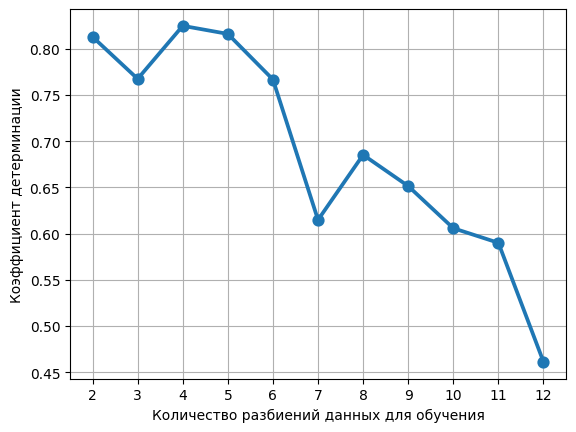

In [109]:
sns.pointplot(x=results.keys(), y=results.values())
plt.grid()
plt.ylabel('Коэффициент детерминации')
plt.xlabel('Количество разбиений данных для обучения')
plt.show()

Как можно заметить, __точность модели падает с ростом количества разбиений данных__

Это означает, что модель склонна __запоминать данные__, а значит на новых данных она будет __неэффективна__.

# Вывод

Лучшая модель - _Логистическая Регрессия_ обученная на сумме всех баллов.

Такой вывод исходит из факта, что с увелечением числа атрибутов (разделение суммы всех баллов на меньшие суммы по смыслу) приводит к ухудшению результатов.

Так же эксперимент с _Линейной Регрессией_ не принес результатов. Возможно, для этого недостаточно данных.